## Imports

In [ ]:
!pip install umap-learn

In [ ]:
## Basic libraries
import pandas as pd
import numpy as np
import re

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category10

from wordcloud import WordCloud, ImageColorGenerator
from scipy.ndimage import gaussian_gradient_magnitude

## Machine learning and NLP
import nltk
import umap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading Data

In [ ]:
# Donwloading files
!wget https://github.com/jaumpedro214/br-laws-clustering-nlp/raw/main/images/congresso_nacional_logo_02.jpg

!wget https://github.com/jaumpedro214/research-nlp-pt-br/raw/main/data/leis_ordinarias.zip
!unzip leis_ordinarias

--2021-08-23 18:32:48--  https://github.com/jaumpedro214/research-nlp-pt-br/raw/main/data/leis_ordinarias.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jaumpedro214/research-nlp-pt-br/main/data/leis_ordinarias.zip [following]
--2021-08-23 18:32:48--  https://raw.githubusercontent.com/jaumpedro214/research-nlp-pt-br/main/data/leis_ordinarias.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18450757 (18M) [application/zip]
Saving to: ‘leis_ordinarias.zip’

leis_ordinarias.zip 100%[===================>]  17.60M   114MB/s    in 0.2s    

2021-08-23 18:32:50 (114 MB/s) - ‘leis_ordinarias.zip

Selecting only texts from 1988 up to now (2021).

In [ ]:
data = pd.read_csv('leis_ordinarias.csv', sep=';')
data = data[data['ano'] > '1988']
len(data)

6402

In [ ]:
texts = data['ementa']

In [ ]:
data.head()

,lei,ementa,ano,inteiro_teor
0,"Lei nº 14.116, de 31.12.2020\nPublicada no DOU...",Dispõe sobre as diretrizes para a elaboração e...,2020,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n ...
1,"Lei nº 14.115, de 29.12.2020\nPublicada no DOU...",Estabelece o aumento da participação da União ...,2020,\n\n\n Presidência da República\n \n\n ...
2,"Lei nº 14.114, de 29.12.2020\nPublicada no DOU...",Abre aos Orçamentos Fiscal e da Seguridade Soc...,2020,\n\n\n Presidência da República\n \n\n ...
3,"Lei nº 14.113, de 25.12.2020\nPublicada no DOU...",Regulamenta o Fundo de Manutenção e Desenvolvi...,2020,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n ...
4,"Lei nº 14.112, de 24.12.2020\nPublicada no DOU...","Altera as Leis n os 11.101, de 9 de fevereiro ...",2020,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n ...


## Data visualization

Lets visualize some text examples

In [ ]:
print(texts[1])
print(texts[21])
print(texts[299])

Estabelece o aumento da participação da União no Fundo Garantidor de Operações (FGO), no montante equivalente ao dos recursos devolvidos à União em conformidade com os §§ 4º e 5º do art. 10 da Lei nº 14.043, de 19 de agosto de 2020.   Mensagem de veto
Abre ao Orçamento de Investimento para 2020, em favor da Empresa Gerencial de Projetos Navais, da Transpetro Bel 09 S.A. e da Amazonas Geração e Transmissão de Energia S.A., crédito especial no valor de R$ 24.340.126,00, para os fins que especifica.
Outorga o título de Patrono da Tecnologia da Informação da Aeronáutica ao Major-Brigadeiro Engenheiro Tércio Pacitti.


## Data Preprocessing

* Change all monetary values to token MONEY
* Change all numbers to token NUMBER
* Remove Brazilian Portuguese stopwords

In [ ]:
def sub_money(text):
  regex_pattern = r'\w[$][ ]\d{1,3}(?:\.\d{3})*?,\d{2}'
  return re.sub(regex_pattern, '<MONEY>', text )

def sub_num(text):
  regex_pattern = r'(\d+.)+'
  return re.sub(regex_pattern, '<NUMBER> ', text )

In [ ]:
texts = texts.apply( sub_money )
texts = texts.apply( sub_num )

In [ ]:
print(texts[1])
print(texts[21])
print(texts[299])

Estabelece o aumento da participação da União no Fundo Garantidor de Operações (FGO), no montante equivalente ao dos recursos devolvidos à União em conformidade com os §§ <NUMBER>  e <NUMBER>  do art. <NUMBER> da Lei nº <NUMBER>  de <NUMBER> de agosto de <NUMBER>    Mensagem de veto
Abre ao Orçamento de Investimento para <NUMBER>  em favor da Empresa Gerencial de Projetos Navais, da Transpetro Bel <NUMBER> S.A. e da Amazonas Geração e Transmissão de Energia S.A., crédito especial no valor de <MONEY>, para os fins que especifica.
Outorga o título de Patrono da Tecnologia da Informação da Aeronáutica ao Major-Brigadeiro Engenheiro Tércio Pacitti.


## Feature Extraction with TF-IDF

* Cutting terms below 0.5% document frequency
* Remove portuguese stopwords

In [ ]:
tfidf_vec = TfidfVectorizer(min_df=0.005, 
                            stop_words=nltk.corpus.stopwords.words('portuguese') ) 
data_tfidf = tfidf_vec.fit_transform( texts ).todense()
pca = PCA( 0.95, random_state=2140)
data_pca = pca.fit_transform(data_tfidf)

In [ ]:
print( f"TF-IDF dimension - {data_tfidf.shape[1]}" )
print( f"TF-IDF + PCA dimension - {data_pca.shape[1]}" )

TF-IDF dimension - 368
TF-IDF + PCA dimension - 248


**Visualizing more important terms**

In [ ]:
N_WORDS = 30
mean_data_tfidf = np.array( data_tfidf.mean( axis=0 ) ).flatten()
vocabulary = tfidf_vec.get_feature_names()
words_id = np.flip( mean_data_tfidf.argsort()[-N_WORDS:] )

word_val_data = [ (vocabulary[id], mean_data_tfidf[id]) for id in words_id ]
word_val_data = pd.DataFrame(word_val_data, columns=['words','values'])

Text(0.5, 1.0, 'Top-30 most important words')

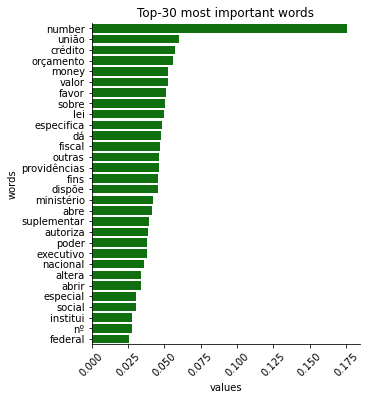

In [ ]:
g = sns.catplot(data=word_val_data, color='green',
                 x='values', y='words', kind='bar' )
g.ax.tick_params(axis='x', rotation=45)
g.ax.set_title( f"Top-{N_WORDS} most important words" )

In [ ]:
print( data_tfidf.shape )
print( data_pca.shape )

(6402, 368)
(6402, 248)


## Clustering with K-means

### Selecting number of clusters

In [ ]:
cluster_sizes = range(2, 20+1)
kmeans_models = [ KMeans(i, n_init=20, random_state=2140) for i in cluster_sizes ]
cluster_score = []

for kmeans in kmeans_models:
  y = kmeans.fit_predict(data_pca)
  score = silhouette_score(data_pca, y)
  cluster_score.append( ( kmeans.n_clusters, score) )

cluster_score=np.array(cluster_score)

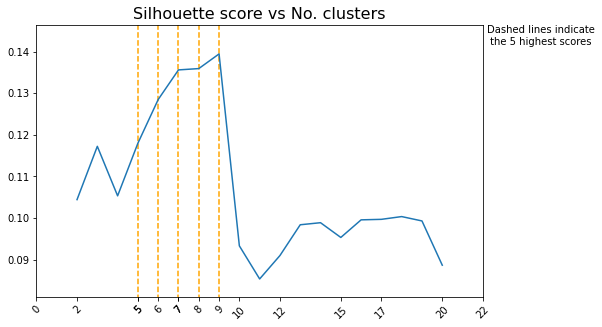

In [ ]:
scores = cluster_score[:, 1]
clusters = cluster_score[:, 0]
max_score_clusters = []

fig, ax = plt.subplots( figsize=(8,5) )
ax = sns.lineplot( x=clusters, y=scores, ax=ax )
ax.set_title("Silhouette score vs No. clusters", fontsize=16)

for i in np.argsort( scores )[-5:]:
  ax.vlines(clusters[i], 0, 1, linestyles='--', colors='orange')
  max_score_clusters.append( clusters[i] )

ax.text(1.01, 1, f"Dashed lines indicate\n the {len(max_score_clusters)} highest scores",
        transform=ax.transAxes, ha='left', va='top')

xticks = ax.get_xticks().astype(int)
xticks = np.append(xticks, max_score_clusters)
ax.set_xticks( xticks )
ax.tick_params(axis='x', rotation=45)

ax.set_ylim( [ 0.95*min(scores), 1.05*max(scores) ] )
ax.set_xlim( [ 0, max(clusters)+2 ] )

plt.show()

We choose one of the best scored cluster numbers. The behavior of silhouette score indicates that probabily the best value to choose is 10. 

This number also eases the visualization and analysis of the clustered data.

In [ ]:
n_clusters=8
kmeans_model = KMeans(n_clusters, n_init=20, random_state=2140)
y = kmeans_model.fit_predict(data_pca)



## Results visualization

### **Silhouette samples**

In [ ]:
sample_scores = silhouette_samples( data_pca, y )
sample_scores_df =  pd.DataFrame( data = {'Cluster':y, 'Silhouette':sample_scores} )
sample_scores_df = sample_scores_df.reset_index()
sample_scores_df=sample_scores_df.sort_values('Silhouette', ascending=False)

In [ ]:
sample_scores_df

,index,Cluster,Silhouette
608,608,3,0.631988
194,194,3,0.631988
1849,1849,3,0.631988
2091,2091,3,0.631988
2421,2421,3,0.631988
...,...,...,...
2052,2052,0,-0.144987
4285,4285,0,-0.146124
1723,1723,0,-0.151663
499,499,0,-0.152980


In [ ]:
def plot_silhouette_samples(X, pred_labels):
  n_clusters = len(np.unique(pred_labels))

  fig, (ax) = plt.subplots(1, 1, figsize=(8,8))
  
  ax.set_xlim([-0.1, 1])
  ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  silhouette_avg = silhouette_score(X, pred_labels)
  sample_silhouette_values = silhouette_samples(X, pred_labels)

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[pred_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
  
    ax.fill_betweenx(np.arange(y_lower, y_upper), 
                     0, ith_cluster_silhouette_values )
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),
            ha='center', va='center', fontsize=12,
            bbox={'boxstyle':'square',
                  'facecolor':'white'})
    y_lower = y_upper + 10
  
  ax.set_title(f"The silhouette score plot for the {n_clusters} clusters.\n",fontsize=20)
  ax.set_xlabel("Silhouette coefficient values",fontsize=18)
  ax.set_ylabel("Cluster",fontsize=18)
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax.set_yticks([])
  ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  return ax

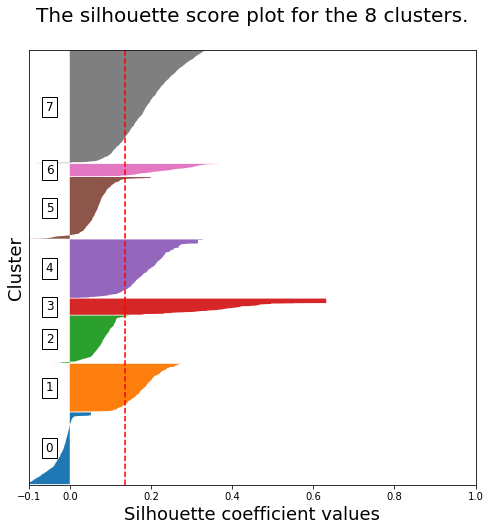

In [ ]:
plot_silhouette_samples(data_pca, y)

### **A few examples of each cluster**

In [ ]:
text_ex

,text,Cluster,Id


In [ ]:
texts_original = data['ementa']

np.random.seed(214)
N_SAMPLE = 3

text_ex = pd.DataFrame( columns=['text', 'Cluster', 'Id' ] )

for i in range( kmeans_model.n_clusters ):
  for id, e in enumerate( texts_original[ np.random.choice( np.argwhere(y==i).flatten(), size=N_SAMPLE ) ] ):
    text_ex.loc[i*N_SAMPLE + id] = [e, i, id]

pd.set_option('display.max_colwidth', 100)
text_ex.set_index(['Cluster', 'Id'])

text
Cluster Id                                                                                                     
0       0       Confere o título de Capital do Semiárido à cidade de Mossoró, no Estado do Rio Grande do Norte.
        1    Confere ao Município de Olímpia, no Estado de São Paulo, o título de Capital Nacional do Folclore.
        2   Institui a campanha nacional de prevenção ao HIV/AIDS e outras infecções sexualmente transmissív...
1       0   Abre ao Orçamento da Seguridade Social da União crédito suplementar no valor de R$ 467.434,00, e...
        1   Abre aos Orçamentos Fiscal e da Seguridade Social da União, em favor do Tribunal de Contas da Un...
        2   Abre aos Orçamentos Fiscal e da Seguridade Social da União, em favor do Ministério do Trabalho e...
2       0   Abre crédito extraordinário, em favor dos Ministérios dos Transportes e da Integração Nacional, ...
        1   Abre crédito extraordinário, em favor do Ministério da Defesa e de Encargos Financeiros da União...
        2   Abre ao Orçamento de Investimento, para 2001, em favor do Banco do Estado do Piauí S.A., crédito...
3       0                                                                    Institui o Dia do Pescador Amador.
        1   Estabelece 2009 como Ano da Educação Profissional e Tecnológica e o dia 23 de setembro como o Di...
        2                                                Institui o Dia Nacional do Cooperativismo de Crédito. 
4       0   Autoriza o Poder Executivo a abrir ao Orçamento Fiscal da União, em favor do Ministério da Agric...
        1   Autoriza o Poder Executivo a abrir ao Orçamento Fiscal da União, em favor do Supremo Tribunal Fe...
        2   Autoriza o Poder Executivo a abrir ao Orçamento Fiscal da União crédito especial até o limite de...
5       0                   Dispõe sobre a regulamentação da profissão de Historiador e dá outras providências.
        1   Dispõe sobre a criação de funções comissionadas no Quadro de Pessoal do Tribunal Regional do Tra...
        2   Dispõe sobre o contrato de trabalho por prazo determinado e dá outras providências. Mensagem de ...
6       0   Denomina "subestação Delfino Araújo Macedo" a subestação de energia elétrica do Linhão Norte-Sul...
        1   Denomina Rodovia Frei Jorge o trecho da rodovia BR-251 localizado no perímetro urbano da cidade ...
        2   Denomina "Aeroporto de Porto Velho/Governador Jorge Teixeira de Oliveira" o Aeroporto de Porto V...
7       0   Altera as Leis nºs 12.468, de 26 de agosto de 2011, e 6.094, de 30 de agosto de 1974; e dá outra...
        1   Altera dispositivos do Decreto-Lei n o 3.689, de 3 de outubro de 1941 – Código de Processo Penal...
        2   Altera a Lei nº 5.917, de 10 de setembro de 1973, que aprova o Plano Nacional de Viação, de modo...

### **Most Important words in each cluster**

In [ ]:
def most_important_words(data_tfidf, y, topn=10):

  n_clusters = len(np.unique(y))
  result = []
  for i in range(n_clusters):
    ith_cluter_word_sum = np.mean(data_tfidf[np.argwhere(y==i).flatten()], axis=0)
    
    word_ids = np.array( np.argsort( ith_cluter_word_sum )[0, -topn:] )
    word_ids = word_ids.reshape( -1 )
    result = result + [ (i, id, ith_cluter_word_sum[0, id] ) for id in word_ids ]

  return result

In [ ]:
word_cluster_df = pd.DataFrame( most_important_words( data_tfidf, y, topn=5 ), columns=["Cluster", "WordId", "Score"] )
word_cluster_df["Word"] = word_cluster_df["WordId"].apply( lambda id: tfidf_vec.get_feature_names()[id] )
word_cluster_df = word_cluster_df.sort_values( "Score", ascending=False )
word_cluster_df.head()

,Cluster,WordId,Score,Word
19,3,102,0.595812,dia
39,7,235,0.558251,number
18,3,191,0.408137,institui
17,3,228,0.362780,nacional
34,6,94,0.324030,denomina


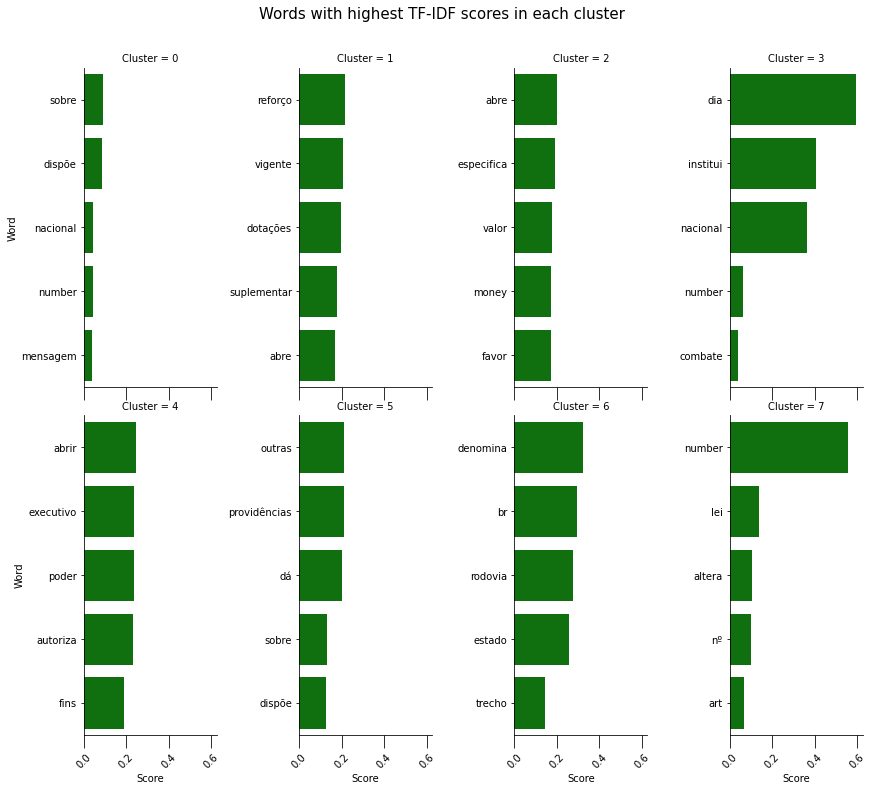

In [ ]:
g = sns.catplot(x="Score", y="Word", col="Cluster", data=word_cluster_df, 
                sharey=False, col_wrap=4, kind="bar",
                color = 'green', aspect=.6)
[ ax.tick_params(axis='x', rotation=45, size=13) for ax in g.axes.flatten() ]
g.fig.suptitle( "Words with highest TF-IDF scores in each cluster", y = 1.05, fontsize=15 )
plt.show()

**Manual Table**

<table>
    <thead>
        <tr>
            <th colspan=4>Words with highest TF-IDF </th>
        </tr>
    </thead>
    <thead>
        <tr>
            <th>Cluster 0</th>
            <th>Cluster 1</th>
            <th>Cluster 2</th>
            <th>Cluster 3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>sobre - about</td>
            <td>reforço - reinforcement</td>
            <td>abre - open</td>
            <td>dia - day</td>
        </tr>
        <tr>
            <td>dispõe - dispose</td>
            <td>vigente - current</td>
            <td>especifica - specific</td>
            <td>institui - institutes</td>
        </tr>
        <tr>
            <td>nacional - nacional</td>
            <td>dotações - allocation</td>
            <td>valor - value</td>
            <td>nacional - nacional</td>
        </tr>
    </tbody>
    </thead>
    <thead>
        <tr>
            <th>Cluster 4</th>
            <th>Cluster 5</th>
            <th>Cluster 6</th>
            <th>Cluster 7</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>abrir open</td>
            <td>outras - others</td>
            <td>denomina - denominate</td>
            <td>number</td>
        </tr>
        <tr>
            <td>executivos - executives</td>
            <td>providência - providence</td>
            <td>br</td>
            <td>lei - law</td>
        </tr>
        <tr>
            <td>autoriza - authorize </td>
            <td>sobre - about</td>
            <td>estado - state</td>
            <td>nº</td>
        </tr>
    </tbody>
</table>

### **2D view of clusters and data with U-Map**

In [ ]:
output_notebook()

In [ ]:
umap_red = umap.UMAP(n_neighbors=12, metric='correlation', 
                     random_state=214)
data_2d = umap_red.fit_transform( data_pca )

In [ ]:
data_2d_df = pd.DataFrame( data={"x":data_2d[:, 0], 
                                 "y":data_2d[:, 1], 
                                 "Cluster":y,
                                 "Silhouette":sample_scores } )

c_pallete = list(Category10[10])
c_pallete[7], c_pallete[0] = c_pallete[0], c_pallete[7]

data_2d_df['colors'] = [ c_pallete[i] for i in data_2d_df['Cluster'] ]
data_2d_df['ementa'] = data['ementa']
#Limiting the text's size
data_2d_df['ementa'] = data_2d_df['ementa'].apply( lambda s: s[:100]+'...' if len(s)>100 else s )

data_2d_df, _,_,_ = train_test_split(data_2d_df, data_2d_df, train_size=4500, stratify=data_2d_df['Cluster'])

data_2d_cdf = ColumnDataSource(data_2d_df)

In [ ]:
fig = figure(
    title='UMAP 2D projection of the points and clusters',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset', 'save')
)

fig.add_tools(HoverTool(tooltips="""
                                      <div>
                                        <span style='font-size: 10px; color: @colors'>@ementa</span>
                                        <span style='font-size: 10px'>cluster - </span>
                                        <span style='font-size: 10px'>@Cluster ;</span>
                                        <span style='font-size: 10px'>index - </span>
                                        <span style='font-size: 10px'>$index ;</span>
                                        <span style='font-size: 10px'>silhouette: </span>
                                        <span style='font-size: 10px'>@Silhouette</span>
                                      </div>
                                 """)
              )

fig.circle('x','y', source=data_2d_cdf, color='colors', 
           legend_group="Cluster",
           line_alpha=0.6, fill_alpha=0.6, size=2)

show(fig)
save(fig, "UMAP2D.html")

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/content/UMAP2D.html'

### **Word Clouds for fancier vocabulary visualizations**

In [ ]:
wc_stopwords = nltk.corpus.stopwords.words('portuguese')+['NUMBER']

In [ ]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
  c = congress_mask[ position[0], position[1] ]
  # Paint word with a solid color from the point where it was written
  # the native function of WordCloud use the mean color from neighbours points
  # and its very messy

  return f"rgb({c[0]}, {c[1]}, {c[2]})"

def color_func2(word, font_size, position, orientation, random_state=None, **kwargs):
  # Paint non-white words with a constant color
  c = congress_mask[ position[0], position[1] ]
  if ( ([255,255,255] - c).sum() > 10 ):
    c = [50, 144, 252]
  return f"rgb({c[0]}, {c[1]}, {c[2]})"

# Just change the blues and greens of the image to a fancier version 
def color_func3(word, font_size, position, orientation, random_state=None, **kwargs):
  c = congress_mask[ position[0], position[1] ]

  ## Changes the green
  if ( np.abs([  0, 139, 211] - c).sum() < 10 ):
    c = [71, 148, 255]
  ## Changes the green
  elif ( np.abs([ 81, 175,  53] - c).sum() < 10 ):
    c = [86, 184, 77]
  else:
    pass

  return f"rgb({c[0]}, {c[1]}, {c[2]})"

# Opening the image and transforming it in a numpy array
congress_img = np.array( Image.open('congresso_nacional_logo_02.jpg') )
congress_mask = congress_img.copy()

# Calculating the image edges
edges = np.mean([gaussian_gradient_magnitude(congress_mask[:, :, i] / 255., 2) for i in range(3)], axis=0)

# Masking the edges out
mask = edges > .05
mask_w = np.zeros( ( mask.shape[0], mask.shape[1], 4 ) )
mask_w[ :, : ] = [0,0,0,255] # All the mask is black
mask_w[ mask ] = 255 # Except for the edges, that are White

/usr/local/lib/python3.7/dist-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


(-0.5, 1160.5, 579.5, -0.5)

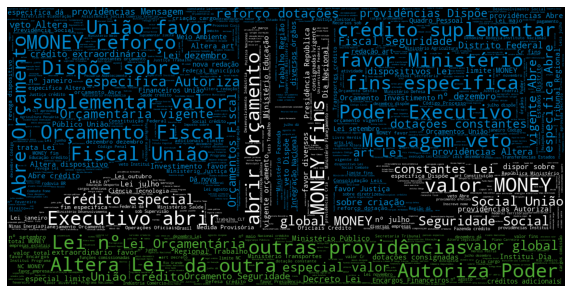

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), )
wc = WordCloud(max_words=1000, mask=mask_w, 
               max_font_size=40, min_font_size=4,
               random_state=214, repeat=True, 
               stopwords=wc_stopwords)

image_colors = color_func
wc.generate_from_text( ' '.join(texts.to_list()) )
wc.recolor(color_func=image_colors)
ax.imshow(wc)
ax.axis('off')

(-0.5, 1160.5, 579.5, -0.5)

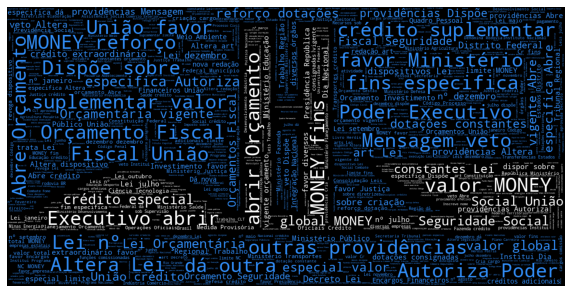

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), )
image_colors = color_func2
wc.recolor(color_func=color_func2)
ax.imshow(wc)
ax.axis('off')

(-0.5, 1160.5, 579.5, -0.5)

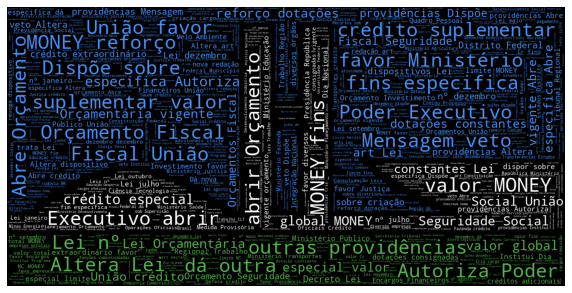

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), )
wc.recolor(color_func=color_func3)
ax.imshow(wc)
ax.axis('off')

### **Word Clouds for fancier (cluster x vocabulary) visualizations**

In [ ]:
def generate_colorfunc( img ):
  return lambda word, font_size, position, orientation, random_state=None, **kwargs: f"rgb({img[position[0]][position[1]][0]}, {img[position[0]][position[1]][1]}, {img[position[0]][position[1]][2]})"


def generate_colorfunc_replace_color( img, color ):
  # replace any color far away from white with a constant color
  img[ ([255,255,255] - img).sum(axis=2) > 20 ] = color

  # Build a function to generate colors
  return lambda word, font_size, position, orientation, random_state=None, **kwargs: f"rgb({img[position[0]][position[1]][0]}, {img[position[0]][position[1]][1]}, {img[position[0]][position[1]][2]})"

In [ ]:
## Split the mask into the pre-defined number of pieces
def split_mask_into_pieces(mask, pieces=10):
  mask = np.split( mask[:,  :pieces*(mask.shape[1]//pieces)], indices_or_sections=pieces, axis=1 )
  return mask

## Building a data frame with the mean tf-idf scores
## of each word in each cluster
word_cluster_full_df = pd.DataFrame(most_important_words( data_tfidf, y, topn=25 ), 
                                    columns=["Cluster", "WordId", "Score"] )
word_cluster_full_df["Word"] = word_cluster_full_df["WordId"].apply( lambda id: tfidf_vec.get_feature_names()[id] )

In [ ]:
## Adding a few extra lines to the top and botton of the figure,
## Just to make it look nicer
congress_mask = np.vstack( [np.repeat(congress_mask[[-1], :, :], 300, axis=0), congress_mask] )
congress_mask = np.vstack( [congress_mask, np.repeat(congress_mask[[-1], :, :], 50, axis=0)] )

mask_w = np.vstack( [np.repeat(mask_w[[-1], :, :], 300, axis=0), mask_w] )
mask_w = np.vstack( [mask_w, np.repeat(mask_w[[-1], :, :], 50, axis=0)] )

/usr/local/lib/python3.7/dist-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


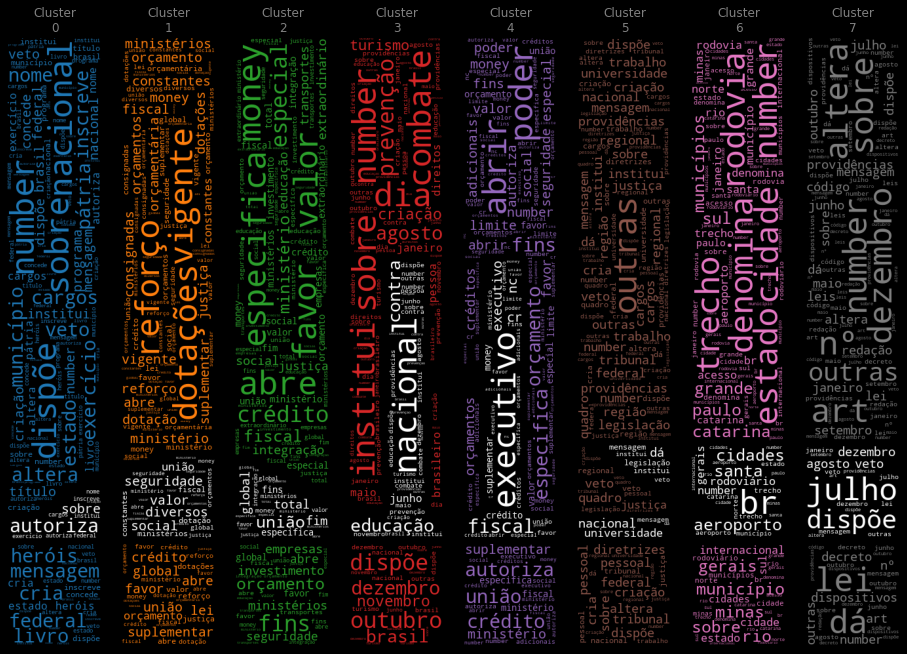

In [ ]:
# Mask and color splits
mask_ws = split_mask_into_pieces(mask_w, pieces=n_clusters)
color_s =split_mask_into_pieces(congress_mask, pieces=n_clusters)

# Setting a color for each cluster
cluster_colors = [ plt.get_cmap('tab10')(i) for i in range(n_clusters) ]
# this transformation is done because matplotlib stores RGB in range 0-1
cluster_colors = [ (255*c[0], 255*c[1], 255*c[2]) for c in cluster_colors ]

# Creating the matplotlib axes to plot the WordClouds
fig, axs = plt.subplots( nrows = 1, ncols=n_clusters, figsize = (16,16) )
fig.patch.set_facecolor('black')

# A list to store the word clouds rendered
wcs = []

for i in range(n_clusters):
  
  ## Building words importance for each cluster
  word_scores = word_cluster_full_df.query(f"Cluster == {i}")
  word_scores = word_scores.set_index("Word").drop( ["Cluster","WordId"],axis=1 )
  word_scores = word_scores.to_dict()['Score']

  ## Creating the word cloud
  wc = WordCloud(max_words=150, mask=mask_ws[i], 
                 max_font_size=50, min_font_size=4,
                 random_state=214, repeat=True,
                 stopwords=wc_stopwords)
  
  ## Fitting the Word cloud
  wc.generate_from_frequencies( word_scores )

  ## Recolor each cluster with its respective color
  wc.recolor(color_func= generate_colorfunc_replace_color(color_s[i], cluster_colors[i][:3]) )
  wcs.append(wc)

  ## Plotting
  axs[i].imshow( wc )
  axs[i].axis('off')
  axs[i].set_title(f"Cluster\n{i}", color='Grey')